In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
import statsmodels.api as sm
from statsmodels.formula.api import logit, glm, ols

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import math
from sklearn.svm import LinearSVC

# First import our dataset & dictionary

In [2]:
# with open("IMDB_dftouse_dict.json", "r") as fd:
#     IMDB_dftouse_dict = json.load(fd)
# maas_IMDB = pd.DataFrame(IMDB_dftouse_dict)

with open("valence_df_dict.json", "r") as fp:
    valence_df_dict = json.load(fp)
maas_IMDB = pd.DataFrame(valence_df_dict)

In [3]:
maas_IMDB.head()

,movie_id,movie_name,n_scorables,pct_scorables,positive,stars,text,url,valence_avg,valence_sum
0,10027,Titanic,120,0.666667,1,7,"Sure, Titanic was a good movie, the first time...",http://www.imdb.com/title/tt0120338/usercommen...,0.479760,38.380826
1,10028,Titanic,65,0.538462,1,10,When I saw this movie I was stunned by what a ...,http://www.imdb.com/title/tt0120338/usercommen...,0.508760,17.806611
10,10037,Titanic,95,0.589474,1,9,The ship may have sunk but the movie didn't!!!...,http://www.imdb.com/title/tt0120338/usercommen...,0.700832,39.246578
100,11015,Cliffhanger,84,0.500000,1,9,This movie is directed by Renny Harlin the fin...,http://www.imdb.com/title/tt0106582/usercommen...,0.794284,33.359933
1000,10544,The First Power,194,0.618557,0,4,When childhood memory tells you this was a sca...,http://www.imdb.com/title/tt0099578/usercommen...,0.132427,15.891239


In [227]:
maas_IMDB.shape

(4111, 10)

In [4]:
# maas_IMDB[maas_IMDB.movie_id==10030].text[3]

In [5]:
with open("happiness.json", "r") as fp:
    happiness = json.load(fp)

In [6]:
len(happiness)

10222

# Now we begin the Natural Language processing
This will take the form of a few steps. 
0. Punctuation: we will remove punctuation from reviews, so that all words can be recognized
1. Lemmatization: we will reduce words to lemmas
2. Removing stop words: we will remove common words from our vocabulary, because they are unlikely to have been used to express sentiment -- which is what we are interested in


## Emulating HW5
1. For each review create a list of nouns, and a list of adjectives
2. For the nouns, perform LDA to separate them into 2 topics to see if there are 2 topics that are relevant i.e. actors vs. plot or whether it's sequel or a stand alone movie
3. Run the sentiment analysis on the adjectives <b> (N.B. At this point it is still not on an external dataset) </b>
4. Putting the topics and sentiment analysis together (marrying the nouns & the adjectives) 
5. Estimate the overall mean for each movie on each topic

In [7]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

In [8]:
from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS

### 1. For each review create a list of nouns, and a list of adjectives

In [9]:
import re
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")

In [10]:
def get_parts(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2, descriptives2

In [11]:
%%time
# review_parts = maas_IMDB.map(lambda x: get_parts(x.text))
review_parts = []
for index, row in maas_IMDB.iterrows():
    review_parts.append(get_parts(row.text))

CPU times: user 1min 45s, sys: 764 ms, total: 1min 46s
Wall time: 1min 47s


In [12]:
review_parts[1]

([[u'movie', u'movie'],
  [u'movie', u'rating'],
  [u'movie', u'acting'],
  [u'job'],
  [u'<br', u'day'],
  [u'effect', u'more.<br', u'movie', u'rent']],
 [[u'great'],
  [u'star'],
  [u'superb'],
  [u'better'],
  [u'rainy'],
  [u'acting', u'special']])

### 2. For the nouns, perform LDA to separate them into 2 topics

In [13]:
ldadata = [ele[0] for ele in review_parts]

In [14]:
ldadata

[[[u'sure', u'movie', u'time', u'time', u'opinion', u'film', u'change'],
  [u'time', u'movie', u'ooh'],
  [u'time', u'movie', u'thinking', u'd**n', u'ship'],
  [u'time'],
  [u'acting', u'film'],
  [u'oscar', u'film'],
  [u'movie', u'film'],
  [u'film'],
  [u'eye', u'character', u'film'],
  [u'performance', u'hand'],
  [u'director', u'film', u'magnitude'],
  [u'lesson', u'movie', u'love-story', u'filmmaker', u'romance', u'movie'],
  [u'film']],
 [[u'movie', u'movie'],
  [u'movie', u'rating'],
  [u'movie', u'acting'],
  [u'job'],
  [u'<br', u'day'],
  [u'effect', u'more.<br', u'movie', u'rent']],
 [[u'picture'],
  [u'scene', u'dinner', u'table', u'scene', u'family', u'friend'],
  [u'look',
   u'face',
   u'woman',
   u'room',
   u'future',
   u'husband.<br',
   u'connection',
   u'movie',
   u'movie',
   u'stuff'],
  [u'mom', u'associate', u'husband', u'wealth'],
  [u'risk.<br', u'movie'],
  [u'story', u'flow', u'actor']],
 [[u'movie', u'miracle'],
  [u'mountain', u'terrorist'],
  [u'mou

In [15]:
import itertools as IT
import collections

def flatten_iter(iterable, ltypes=collections.Iterable):
    remainder = iter(iterable)
    while True:
        first = next(remainder)
        if isinstance(first, ltypes) and not isinstance(first, basestring):
            remainder = IT.chain(first, remainder)
        else:
            yield first

In [16]:
vocab_raw = list(flatten_iter(ldadata))
#removing duplicates
vocab_unique = []
for i in vocab_raw:
    if i not in vocab_unique:
        vocab_unique.append(i)

In [17]:
vocab = {}
for i in range(len(vocab_unique)):
    vocab[vocab_unique[i]] = i
    
id2word = {}
for i in range(len(vocab_unique)):
    id2word[i] = vocab_unique[i]

In [18]:
id2word[0], vocab.keys()[5], vocab[vocab.keys()[5]]

(u'sure', u'yellow', 5224)

In [19]:
from collections import defaultdict

def auxillary_function(ldadata, vocab):
    d = defaultdict(int)
    for i in ldadata: 
        index = vocab[i]
        d[index] += 1
    return d.items()

In [31]:
all_reviews = []
for i in ldadata: # into a review
    this_review = []
    for j in i:
        for k in j: 
            if k not in this_review: 
                this_review.append(k)
    all_reviews.append(this_review)

corpus = []
for i in all_reviews: 
    corpus.append(auxillary_function(i, vocab))

In [32]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1)],
 [(1, 1),
  (10, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1)],
 [(1, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1)],
 [(64, 1),
  (1, 1),
  (66, 1),
  (67, 1),
  (4, 1),
  (69, 1),
  (68, 1),
  (65, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1)],
 [(1, 1),
  (2, 1),
  (25, 1),
  (30, 1),
  (48, 1),
  (55, 1),
  (61, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),


In [22]:
import gensim

In [23]:
lda2 = gensim.models.ldamodel.LdaModel(corpus, num_topics=2,id2word = id2word,update_every=1,chunksize=20000,passes=1)

In [24]:
lda2.print_topics()

[u'0.026*movie + 0.017*film + 0.013*time + 0.012*character + 0.009*scene + 0.008*story + 0.008*thing + 0.008*way + 0.008*person + 0.007*plot',
 u'0.020*movie + 0.016*film + 0.011*story + 0.010*character + 0.008*time + 0.007*person + 0.007*actor + 0.006*scene + 0.005*performance + 0.005*thing']

In [25]:
for bow in corpus[0:900:15]:
    print bow
    print lda2.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)]
[(0, 0.95077430503179938), (1, 0.049225694968200652)]
sure movie time opinion film change ooh thinking d**n ship acting oscar eye character performance hand director magnitude lesson love-story filmmaker romance
[(1, 1), (4, 1), (342, 1), (135, 1), (267, 1), (12, 1), (13, 1), (15, 1), (24, 1), (150, 1), (151, 1), (280, 1), (26, 1), (346, 1), (176, 1), (214, 1), (304, 1), (294, 1), (295, 1), (296, 1), (297, 1), (298, 1), (299, 1), (300, 1), (301, 1), (302, 1), (303, 1), (48, 1), (305, 1), (306, 1), (307, 1), (308, 1), (309, 1), (310, 1), (311, 1), (312, 1), (313, 1), (314, 1), (315, 1), (316, 1), (317, 1), (318, 1), (319, 1), (320, 1), (321, 1), (322, 1), (323, 1), (324, 1), (325, 1), (326, 1), (327, 1), (328, 1), (329, 1), (330, 1), (55, 1), (332, 1), (333, 1), (78, 1), (335, 1), (336, 1), (337, 1), 

It looks like <b> topic 2</b> is about the external factors of a movie -- who the actors are and how production went, and <b> topic 1</b> is about the intrinsic factors of a movie -- the character development and plot. Examples: 
    * words like "movie" "actor" "film" or "budget" "film" have higher topic 2 ratings. 
    * words like "relationship" "scenery" "personality" have a higher topic 1 rating

### 3. Run the sentiment analysis on the adjectives

In [26]:
nbdata = [ele[1] for ele in review_parts]

In [27]:
adj_raw = list(flatten_iter(nbdata))
#removinc duplicates
adj_unique = []
for i in adj_raw:
    if i not in adj_unique:
        adj_unique.append(i)

In [28]:
adjvocab = {}
for i in range(len(adj_unique)):
    adjvocab[adj_unique[i]] = i

In [29]:
adjvocab['great']

7

In [30]:
len(adjvocab)

7335

In [40]:
import itertools
Xarray = []
for i in nbdata: # into a review
    Xarraypre = " ".join(list(itertools.chain.from_iterable(i)))
    Xarray.append(Xarraypre)

In [120]:
# making the response array based off of the sentiment dictionary 'happiness' there is valence_avg and valence_sum
resparray = []
for index, row in maas_IMDB.iterrows():
    if row.valence_avg > 0: # need to make it binomial because that's how the calibration/cv score works
        resparray.append(1)
    else: 
        resparray.append(0)

In [123]:
print  len(Xarray), len(resparray)
print Xarray[0]

4111 4111
good second love-story romantic second annoying impressive bad great glad half-good suprised worst wonderful talented crummy single possible mere


In [124]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(len(Xarray)), train_size=0.7)
mask=np.ones(len(Xarray), dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [134]:
X=np.array(Xarray)
y=np.array(resparray)

In [135]:
y

array([1, 1, 1, ..., 1, 0, 1])

In [136]:
def make_xy(X_col, y_col, vectorizer):
    X = vectorizer.fit_transform(X_col)
    y = y_col
    return X, y

In [137]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to 
a Naive Bayes classifier. 
The Log Likelihood is defined by

L = Sum_positive(logP(positive)) + Sum_negative(logP(negative))

Where Sum_positive indicates a sum over all positive reviews, 
and Sum_negative indicates a sum over negative reviews
    
Parameters
----------
clf : Naive Bayes classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is positive
"""
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    neg = y == 0
    pos = ~neg
    return prob[neg, 0].sum() + prob[pos, 1].sum()

In [138]:
from sklearn.cross_validation import KFold

def cv_score(clf, x, y, score_func, nfold=5):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by splitting (x, y) into 5 folds of training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    result = 0
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [139]:
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(+)")
    
    #the distribution of P(+)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(+)")
    plt.ylabel("Number")

In [140]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [141]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(vocabulary =adjvocab, min_df = min_df)       
        Xthis, Ythis = make_xy(X[mask], y[mask], vectorizer)
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xthis, Ythis, log_likelihood)
        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

In [142]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 0.100000
min_df: 0.000010


Accuracy on training data: 0.97
Accuracy on test data:     0.89


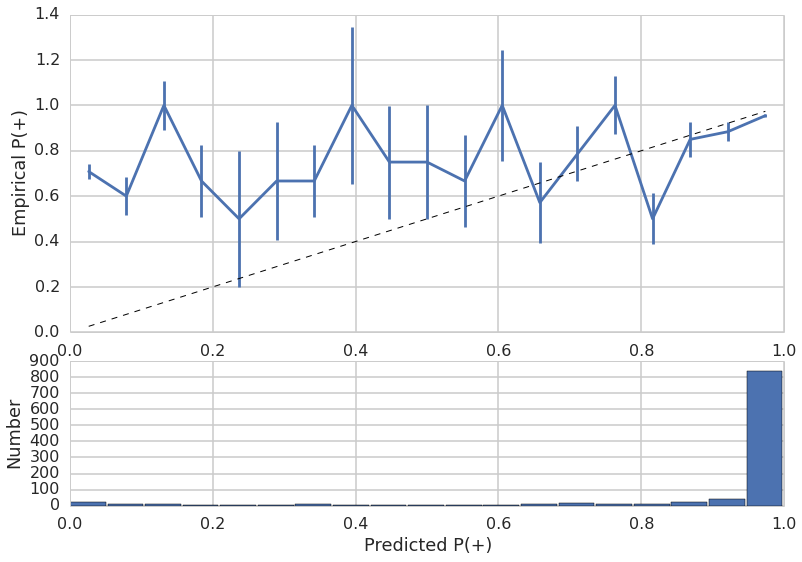

In [143]:
vectorizer = CountVectorizer(vocabulary =adjvocab, min_df=best_min_df)
Xnew, Ynew = make_xy(X,y, vectorizer)
xtrain, xtest, ytrain, ytest = train_test_split(Xnew, Ynew)
clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

calibration_plot(clf, xtest, ytest)

### 4. Putting the topics and sentiment analyses together

In [144]:
vectorizer_alladj = CountVectorizer(min_df=best_min_df,vocabulary = adjvocab)
X_alladj, Y_alladj = make_xy(X[mask],y[mask], vectorizer_alladj)
clf_alladj = MultinomialNB(alpha=best_alpha).fit(X_alladj, Y_alladj)

logpositives = dict(zip(vectorizer_alladj.get_feature_names(),clf_alladj.feature_log_prob_[0]))
lognegatives = dict(zip(vectorizer_alladj.get_feature_names(),clf_alladj.feature_log_prob_[1]))

In [145]:
def calc_pplus(adjlist, lp, ln, pp,pn):
    sgivenpos = 0
    sgivenneg = 0
    for adj in adjlist:
        sgivenpos += lp[adj]
        sgivenneg += ln[adj]
    return(np.exp(sgivenpos)*pp)/(np.exp(sgivenpos)*pp + np.exp(sgivenneg)*pn)

In [196]:
reviews=[]
for index, row in maas_IMDB.iterrows():
    reviews.append(row.movie_id)

In [198]:
reviews

[10027.0,
 10028.0,
 10037.0,
 11015.0,
 10544.0,
 10714.0,
 10715.0,
 10716.0,
 10717.0,
 10718.0,
 10719.0,
 10753.0,
 10754.0,
 10755.0,
 11016.0,
 10756.0,
 10757.0,
 10758.0,
 10759.0,
 10760.0,
 10775.0,
 10776.0,
 10777.0,
 10778.0,
 10779.0,
 11017.0,
 10780.0,
 10781.0,
 10782.0,
 10783.0,
 10784.0,
 10785.0,
 10786.0,
 10787.0,
 10788.0,
 10794.0,
 11018.0,
 10795.0,
 10796.0,
 10797.0,
 10798.0,
 10799.0,
 10800.0,
 10801.0,
 10802.0,
 10803.0,
 10804.0,
 11019.0,
 10805.0,
 10806.0,
 10807.0,
 10808.0,
 10809.0,
 10810.0,
 10811.0,
 10812.0,
 10826.0,
 10827.0,
 11020.0,
 10828.0,
 10829.0,
 10830.0,
 10831.0,
 10832.0,
 10833.0,
 10834.0,
 10835.0,
 10836.0,
 10837.0,
 11021.0,
 10838.0,
 10902.0,
 10903.0,
 10904.0,
 10905.0,
 10906.0,
 10907.0,
 10908.0,
 10909.0,
 10910.0,
 11022.0,
 10911.0,
 10912.0,
 10913.0,
 10914.0,
 11035.0,
 11088.0,
 11089.0,
 11090.0,
 11091.0,
 11092.0,
 11023.0,
 11093.0,
 11118.0,
 11119.0,
 11120.0,
 11158.0,
 11159.0,
 11160.0,
 11161.0,


In [199]:
len(review_parts),len(reviews)

(4111, 4111)

In [200]:
def choose_topic(ldamodel, bow):
    tee = lda2.get_document_topics(bow)
    if len(tee)==2:
        t1,t2=tee
        if t2[1] >= t1[1]:#get higher probability topic
            topicis=t2[0]
        else:
            topicis=t1[0]
    elif len(tee)==1:#if only one was provided its very high probability. Take it
        teetuple=tee[0]
        topicis=teetuple[0]
    return topicis

In [201]:
priorp = np.mean(resparray)
priorn = 1 - priorp
priorp, priorn

(0.92897105327171003, 0.071028946728289966)

In [202]:
counter=0
reviewdict={}
for i, rid in enumerate(reviews):
    rlist=[]
    nlist, alist = review_parts[i]
    ln=len(nlist)
    localbow=corpus[counter:counter+ln]
    for bow, adj, noun in zip(localbow, alist, nlist):
        doc=" ".join([id2word[e[0]] for e in bow])
        pplus=calc_pplus(adj, logpositives, lognegatives, priorp, priorn)
        topicis=choose_topic(lda2, bow)
        ldict={"topic": topicis, 'pplus':pplus}
        rlist.append(ldict)
    reviewdict[rid]=rlist
    counter=counter+ln

In [212]:
list_of_dicts=[]
for index, row in maas_IMDB.iterrows():
    revs=reviewdict[row.movie_id]
    for r in revs:
        r2=r.copy()
        r2['movie_id']=row.movie_name
        r2['url']=row.url
        r2['review_id']=row.movie_id
        r2['stars']=row.stars
        r2['valence_avg']=row.valence_avg
        r2['valence_sum']=row.valence_sum
        list_of_dicts.append(r2)

In [214]:
completedf=pd.DataFrame(list_of_dicts)
completedf.head()

,movie_id,pplus,review_id,stars,topic,url,valence_avg,valence_sum
0,Titanic,0.920797,10027,7,0,http://www.imdb.com/title/tt0120338/usercommen...,0.479760,38.380826
1,Titanic,0.878150,10028,10,0,http://www.imdb.com/title/tt0120338/usercommen...,0.508760,17.806611
2,Titanic,0.659934,10037,9,1,http://www.imdb.com/title/tt0120338/usercommen...,0.700832,39.246578
3,Cliffhanger,0.466197,11015,9,1,http://www.imdb.com/title/tt0106582/usercommen...,0.794284,33.359933
4,The First Power,0.988811,10544,4,0,http://www.imdb.com/title/tt0099578/usercommen...,0.132427,15.891239


In [226]:
completedf.shape

(4111, 8)

### 5. Estimate the overall mean for each movie on each topic

In [219]:
def get_stats(group):
    min_pplus = group.pplus.min()
    max_pplus = group.pplus.max()
    rid = group.movie_id.unique()
    valence_avg = group.valence_avg.mean()
    valence_sum = group.valence_sum.mean()
    count = group.topic.count()
    if count == 1: 
        varj = 0
    else: 
        varj = group.pplus.var(ddof=1)
    mean_pplus = group.pplus.mean()
    stars = group.stars.mean()
    return pd.DataFrame({'min': min_pplus, 'max':max_pplus ,'valence_avg': valence_avg,'valence_sum':valence_sum, 
                         'count': count,'var': varj, 'mean': mean_pplus, 'stars': stars}, index=rid)

In [220]:
%%time
dftouse=completedf.groupby(['review_id', 'topic']).apply(get_stats).reset_index()

CPU times: user 562 ms, sys: 4.86 ms, total: 567 ms
Wall time: 584 ms


In [223]:
print dftouse.shape
dftouse.head()

(379, 11)


,review_id,topic,level_2,count,max,mean,min,stars,valence_avg,valence_sum,var
0,7455,1,Corky Romano,1,0.939821,0.939821,0.939821,3,0.040475,0.566644,0
1,7456,0,Corky Romano,1,0.047297,0.047297,0.047297,2,0.196665,8.259933,0
2,7457,1,Corky Romano,1,0.967750,0.967750,0.967750,4,0.218332,9.169933,0
3,7458,0,Corky Romano,4,0.967750,0.967750,0.967750,3,0.134703,23.438296,0
4,7487,1,The Out-of-Towners,1,0.932418,0.932418,0.932418,1,0.352145,22.889421,0


In [224]:
dftouse[dftouse.review_id==10037]

,review_id,topic,level_2,count,max,mean,min,stars,valence_avg,valence_sum,var
141,10037,1,Titanic,1,0.659934,0.659934,0.659934,9,0.700832,39.246578,0


## Using the NLTK library

In [130]:
! pip install nltk

In [131]:
import nltk
from nltk.corpus import sentiwordnet as swn

ImportError: cannot import name sentiwordnet

In [30]:
happy = swn.senti_synset('happy.n.03')
>>> print(happy)

NameError: name 'swn' is not defined

In [25]:
type(wn)

nltk.corpus.util.LazyCorpusLoader